# Genetic traveling salesman problem
In this notebook, we are going to implement, explore, and optimize the genetic TSP algorithm - compared with a simple nearest neighbor algorithm. We will use both randomly generated datasets and prepared [Florida State University datasets](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html).

The notebook is a part of the article series.

## Implementation

### Utils
The Utils class provides some common utilities like generating random TSP routes, estimating exact algorithm execution time, and parsing execution time from nanoseconds to human-readable units.


In [1]:
import math
import numpy as np
import random

np.random.seed(728)
random.seed(728)

class TSPUtils:

    PERIODS = (
        ('ms', 1), ('s', 1000.0), ('m', 60.0), ('h', 60.0),
        ('days', 24.0), ('years', 365.242199), (None, math.inf)
    )

    @staticmethod
    def get_random_rates(n):
        result = np.random.randint(1, 100, size=(n,n))
        result = np.tril(result) + np.tril(result, -1).T
        np.fill_diagonal(result,0)
        return result

    @staticmethod
    def parse_timedelta(timedelta):
        if timedelta < 1e6:
            return '< 1 ms'
        timedelta /= 1e6
        for current, next in zip(TSPUtils.PERIODS, TSPUtils.PERIODS[1:]):
            if timedelta < next[1]:
                return f"{timedelta:.2e} {current[0]}" if timedelta >= 1e3 else f"{timedelta:.2f} {current[0]}"
            timedelta /= next[1]

    @staticmethod
    def estimate_run_time_as_number(n, estimated_operation_time_ns = 1.74797e3):
        return math.factorial(n) * estimated_operation_time_ns

    @staticmethod
    def estimate_run_time(n, estimated_operation_time_ns = 1.74797e3):
        return TSPUtils.parse_timedelta(TSPUtils.estimate_run_time_as_number(n, estimated_operation_time_ns=estimated_operation_time_ns))

### Abstract solver
Abstract solver provides a common interface and some methods for all concrete solvers. 
Prices of TSP routes are stored in the *rates* field as a 2d array. The abstract solver takes the *start_node* named parameter so it suggests its subclasses to allow a client to choose the initial city - if it's not given (by default) then the initial city should be randomly chosen. 

In [2]:
from abc import ABC, abstractmethod
from functools import reduce
from operator import add
import time

class TSPSolver(ABC):

    def __init__(self, rates, solver_name, start_node=None):
        self.rates = rates
        self.solver_name = solver_name
        self.start_node = start_node
        self.nodes = [i for i in range(len(rates))]
        self.n = len(self.nodes)

    @abstractmethod
    def solve(self):
        pass

    def solve_and_measure_time(self):
        start_time = time.time_ns()
        result = self.solve()
        elapsed_time = time.time_ns() - start_time
        return *result, elapsed_time

    def calculate_path_price(self, path):
        return reduce(add, [self.rates[path[i]][path[i+1]] for i in range(len(path)-1)]) \
            + self.rates[path[len(path)-1]][path[0]]
    
    def nodes_without_start(self):
        return [node for node in self.nodes if node != self.start_node]

### Random solver
The random solver will be used as some kind of upper threshold for real solvers. It works in 3 steps:
- creates the provided amount of random paths (nodes set permutations),
- calculates path price for each path,
- returns path which price is closest to the mean price of paths.

In [3]:
class RandomSolver(TSPSolver):
    
    def __init__(self, rates, start_node=None):
        super().__init__(rates, "Random solver", start_node)
        
    def solve(self, number_of_experiments=10):
        experiments_range = range(min(self.n, number_of_experiments))
        random_paths = [[self.start_node, *np.random.permutation(self.nodes_without_start())] for _ in experiments_range] \
            if self.start_node else [np.random.permutation(self.nodes) for _ in experiments_range]
        path_prices = [self.calculate_path_price(path) for path in random_paths]
        selected_path_index = np.abs(path_prices - np.mean(path_prices)).argmin()
        return random_paths[selected_path_index], path_prices[selected_path_index]

### Exact (brute force) solver
The exact solver simply creates a set of all permutations (routes) of nodes (cities) set and returns one with the least cost. The possibility of choosing the initial city is ensured.

In [4]:
from itertools import permutations

class ExactSolver(TSPSolver):

    def __init__(self, rates, start_node=None):
        super().__init__(rates, "Exact solver", start_node)

    def solve(self):
        if self.start_node:
            all_possible_paths = [[self.start_node, *path] for path in permutations(self.nodes_without_start())]
        else:
            all_possible_paths = permutations(self.nodes)
        best_path = (None, math.inf)
        for path in all_possible_paths:
            price = self.calculate_path_price(path)
            if price < best_path[1]:
                best_path = (path, price)
        return best_path

### Nearest neighbor solver
NN solver visits each city starting from the initial city (provided or random). The next city to visit is "the nearest" city to the current which hasn't been visited yet.

In [5]:
import math

class NearestNeighborSolver(TSPSolver):

    def __init__(self, rates, start_node=None):
        super().__init__(rates, "Nearest neighbor solver", start_node)

    def solve(self):
        current_node = start_node = self.nodes[random.randint(0, self.n - 1)] if self.start_node is None else self.start_node
        path = [start_node]
        nodes_to_visit = [node for node in self.nodes if node != start_node]
        while len(nodes_to_visit) > 0:
            best_direct_path = self.best_direct_path(nodes_to_visit, current_node)
            path.append(best_direct_path)
            nodes_to_visit.remove(best_direct_path)
            current_node = best_direct_path
        return path, self.calculate_path_price(path)

    def best_direct_path(self, nodes_to_visit, node):
        rates = [self.rates[node][n] for n in nodes_to_visit]
        return nodes_to_visit[rates.index(min(rates))]

### Abstract genetic algorithm
Abstract genetic algorithm provides genetic algorithm framework to its subclass - genetic solver:
- the algorithm is parametrized via constructor arguments,
- in order to run algorithm iteration subclass shall call the *next_generation* method, which:
    1. selects individuals from the current generation,
    2. crossovers selected individuals and creates new generation,
    3. mutates generation. 
- subclass must provide an implementation of:
    1. fitness function
    2. crossover function (crossover pair of individuals)
    3. mutation function (mutate single individual)

The GeneticAlgorithm abstract class has been designed as a generic mixin used by concrete genetic algorithms - solving real problems. It can be used with any problem - not only TSP.

In [6]:
class GeneticAlgorithm(ABC):

    def __init__(self, population, selection_method, mutation_rate, tournament_size=None):
        self.current_generation = population
        self.population_size = len(population)
        self.selection_method = selection_method
        self.mutation_rate = mutation_rate
        if selection_method == "tournament" and not tournament_size:
            raise Exception("Keyword argument 'tournament_size' is required when selection_method is 'tournament'")
        self.tournament_size = tournament_size

    def next_generation(self):
        selection = self.selection()
        self.crossover_population(selection)
        self.mutate_population()

    @abstractmethod
    def calculate_fitness(self, individual):
        pass

    @abstractmethod
    def crossover(self, parents):
        pass

    @abstractmethod
    def mutate(self, individual):
        pass

    def selection(self):
        if self.selection_method == "tournament":
            return self.tournament_selection()
        elif self.selection_method in ["roulette", "rank"]:
            return self.roulette_wheel_selection(rank=self.selection_method=="rank")
        elif self.selection_method == "steady_state":
            return self.steady_state_selection()
        else:
            raise Exception("Invalid selection method")

    def find_best_individual(self, individuals):
        individuals_with_scores = [(individual, self.calculate_fitness(individual)) for individual in individuals]
        individuals_with_scores.sort(key=lambda x: x[1], reverse=True)
        return individuals_with_scores[0][0]

    def tournament_selection(self):
        selection = []
        while len(selection) < self.population_size:
            tournament_individuals = random.sample(self.current_generation, self.tournament_size)
            selection.append(self.find_best_individual(tournament_individuals))
        return selection

    def roulette_wheel_selection(self, rank=False):
        individuals_fitness_inverted = [(index, pow(self.calculate_fitness(individual), -1)) for index, individual in enumerate(self.current_generation)]
        if rank:
            individuals_fitness_inverted.sort(key=lambda rate: rate[1])
            individuals_fitness_inverted = [(rate[0], index + 1) for index, rate in enumerate(individuals_fitness_inverted)]
        total_inverted_fitness = reduce(add, [rate[1] for rate in individuals_fitness_inverted])
        selection = []
        while len(selection) < self.population_size:
            current_point = 0
            spin_point = random.random() * total_inverted_fitness
            for i in range(self.population_size):
                current_point += individuals_fitness_inverted[i][1]
                if current_point > spin_point:
                    selection.append(self.current_generation[i])
                    break
        return selection

    def steady_state_selection(self):
        individuals_fitness = [(index, self.calculate_fitness(individual)) for index, individual in enumerate(self.current_generation)]
        individuals_fitness_sorted = sorted(individuals_fitness, key=lambda pair: pair[1], reverse=True)
        return [self.current_generation[pair[0]] for pair in individuals_fitness_sorted[:2]], individuals_fitness_sorted[-1]

    def crossover_population(self, selection):
        if self.selection_method == "steady_state":
            offspring = self.crossover(selection[0])
            offspring_fitness = self.calculate_fitness(offspring)
            if offspring_fitness < selection[1][1]:
                self.current_generation[selection[1][0]] = offspring
        else:
            new_generation = []
            for i in range(self.population_size):
                new_generation.append(self.crossover(random.sample(selection, 2)))
            self.current_generation = new_generation

    def mutate_population(self):
        mutated_population = []
        for individual in self.current_generation:
            mutated_population.append(self.mutate(individual))
        return mutated_population

### Genetic solver
Genetic solver inherits from 2 classes - *TSPSolver* and *GeneticAlgorithm*. It proxies *calculate_path_price* from the *TSPSolver* class into the *GeneticAlgorithm* class. 

The genetic solver also provides an option to collect results from all generations - not only last - which can be useful for exploring genetic algorithms. 

In [7]:
class GeneticSolver(TSPSolver, GeneticAlgorithm):

    def __init__(self, rates, number_of_generations=100, initial_population=None, population_size=None, selection_method="tournament", mutation_rate=0.01, tournament_size=None):
        super().__init__(rates, 'Genetic solver')
        population_size = population_size if population_size else len(rates)
        tournament_size = tournament_size if tournament_size else int(population_size*0.5)
        GeneticAlgorithm.__init__(self, initial_population if initial_population else [np.random.permutation(self.nodes) for _ in range(population_size)], selection_method, mutation_rate, tournament_size)
        self.number_of_generations = number_of_generations

    def solve(self):
        best_path = self.run()
        return best_path, self.calculate_path_price(best_path)

    def run(self, collect_each_generation=False):
        collected_generations = []
        for generation in range(self.number_of_generations):
            if collect_each_generation:
                collected_generations.append((generation, self.calculate_path_price(self.find_best_individual(self.current_generation))))
            self.next_generation()
        return self.find_best_individual(self.current_generation) if not collect_each_generation else collected_generations

    def calculate_fitness(self, path):
        return 1/self.calculate_path_price(path)

    def crossover(self, parents):
        gene_a_index, gene_b_index = random.randint(0, self.n - 1), random.randint(0, self.n - 1)
        gene_start_index, gene_end_index = min(gene_a_index, gene_b_index), max(gene_a_index, gene_b_index)
        offspring = [parents[0][i] for i in range(gene_start_index, gene_end_index)]
        return offspring + [gene for gene in parents[1] if gene not in offspring]

    def mutate(self, individual):
        for gene in range(len(individual)):
            if random.random() < self.mutation_rate:
                to_swap = (random.randint(0, len(individual) - 1), random.randint(0, len(individual) - 1))
                individual[to_swap[0]], individual[to_swap[1]] = individual[to_swap[1]], individual[to_swap[0]]
        return individual

## Exploration
First, we define the utility function that solves a given TSP dataset with all 3 or 4 solvers. Using the exact solver is optional.

In [8]:
import pandas as pd

def solve_tsp_with_given_solvers(data, solvers, estimate_exact_alg_time=False):
    def safe_add_to_list_in_dict(dictionary, key, value):
        if key in dictionary:
            dictionary[key].append(value)
        else:
            dictionary[key] = [value]
        return dictionary
    result = {}
    for rates in data:
        safe_add_to_list_in_dict(result, 'Number of nodes', len(rates))
        if estimate_exact_alg_time:
            safe_add_to_list_in_dict(result, 'Exact algorithm estimated time', TSPUtils.estimate_run_time(len(rates)))
        for solver in solvers:
            solver_instance = solver(rates)
            solver_result = solver_instance.solve_and_measure_time()
            safe_add_to_list_in_dict(result, f'{solver_instance.solver_name} score', solver_result[1])
            safe_add_to_list_in_dict(result, f'{solver_instance.solver_name} time', TSPUtils.parse_timedelta(solver_result[2]))
    return pd.DataFrame(result)
base_solvers = (RandomSolver, NearestNeighborSolver, GeneticSolver)
base_solvers_with_exact = (ExactSolver, *base_solvers)

In [9]:
SOLVERS_COLORS_MAP = {
    'Exact solver score': '#84cc16', 'Ideal score': '#84cc16',
    'Genetic solver score': '#3b82f6', 'Genetic-NN solver score': '#1d4ed8', 'Genetic-NN-rand solver score': '#93c5fd',
    'Random solver score': '#ef4444', 'Nearest neighbor solver score': '#eab308'
}
def get_solvers_colors(solver_names):
    return [SOLVERS_COLORS_MAP[solver_name] for solver_name in solver_names]
    

### Compare solvers
Solvers will be compared by using:
1. Randomly generated datasets.
2. Real [data from Florida State University](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html).

#### Random data

In [10]:
randomized_data_1 = [TSPUtils.get_random_rates(n) for n in range(5, 11)]
randomized_data_1_solved = solve_tsp_with_given_solvers(randomized_data_1, base_solvers_with_exact)
randomized_data_2 = [TSPUtils.get_random_rates(n) for n in range(5, 100, 10)]
randomized_data_2_solved = solve_tsp_with_given_solvers(randomized_data_2, base_solvers, estimate_exact_alg_time=True)

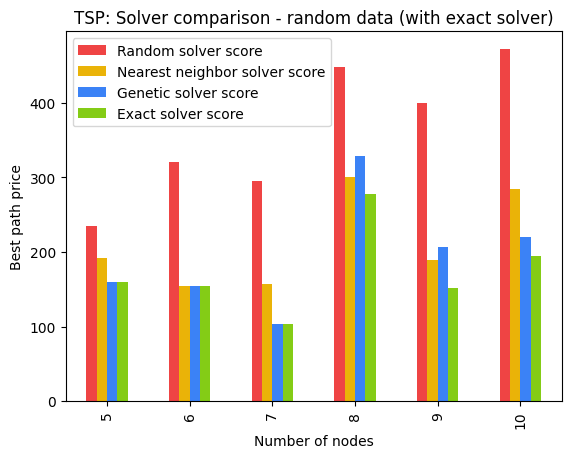

In [11]:
def plot_randomized_data_1_solved():
    y = ['Random solver score', 'Nearest neighbor solver score', 'Genetic solver score', 'Exact solver score']
    randomized_data_1_solved.plot(x='Number of nodes', y=y, color=get_solvers_colors(y),
                                  ylabel='Best path price', kind='bar',
                                  title='TSP: Solver comparison - random data (with exact solver)'
                                  )
plot_randomized_data_1_solved()

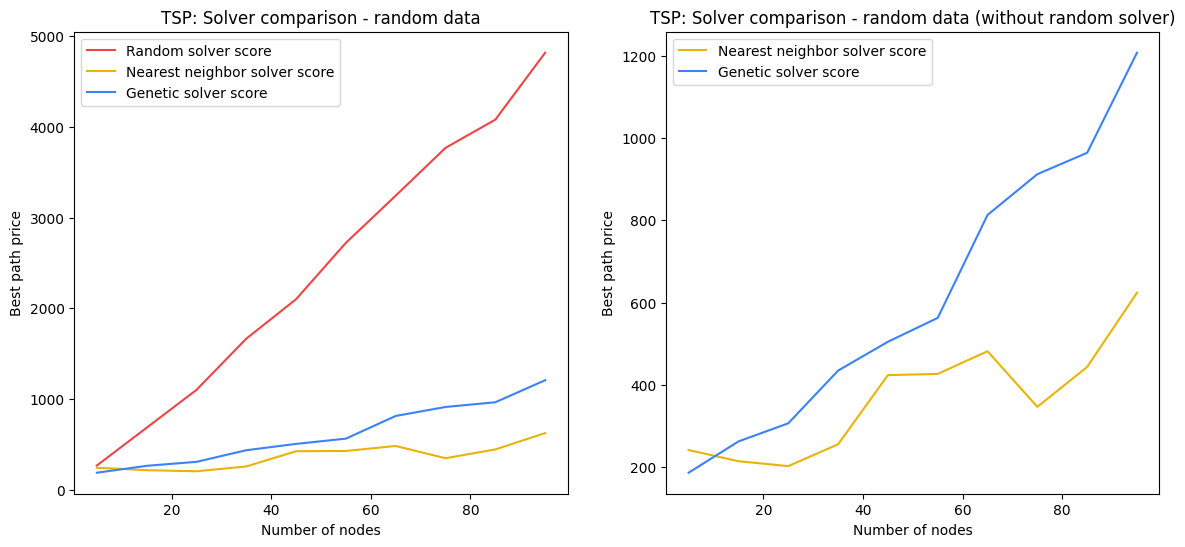

In [12]:
import matplotlib.pyplot as plt

def plot_randomized_data_2_solved():
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    y_1 = ['Random solver score', 'Nearest neighbor solver score', 'Genetic solver score']
    randomized_data_2_solved.plot(x='Number of nodes', y=y_1, color=get_solvers_colors(y_1),
                                  ylabel='Best path price', ax=axs[0],  
                                  title='TSP: Solver comparison - random data',
                                  )
    y_2 = ['Nearest neighbor solver score', 'Genetic solver score']
    randomized_data_2_solved.plot(x='Number of nodes', y=y_2, color=get_solvers_colors(y_2),
                                  ylabel='Best path price', ax=axs[1], 
                                  title='TSP: Solver comparison - random data (without random solver)',
                                  )
    plt.show()

plot_randomized_data_2_solved()

#### FSU data sets

In [13]:
import requests

FSU_TSP_DATA_BASE_URL = "https://people.sc.fsu.edu/~jburkardt/datasets/tsp"
FSU_DATA_SETS = (('five_d', 19), ('att48_d', 33523), ('dantzig42_d', 699), ('fri26_d', 937), ('gr17_d', 2085), ('p01_d', 291))

def load_tsp_data_from_fsu():
    fsu_data = []
    for name, best_path_price in FSU_DATA_SETS:
        raw_data = requests.get(f"{FSU_TSP_DATA_BASE_URL}/{name}.txt").content.decode()
        raw_rows = raw_data.split("\n")
        fsu_data.append((name, best_path_price, [[float(node) for node in row.split()] for row in raw_rows if row != '']))
    return fsu_data
fsu_data = load_tsp_data_from_fsu()

In [14]:
fsu_data_solved = solve_tsp_with_given_solvers([dataset[2] for dataset in fsu_data], base_solvers, estimate_exact_alg_time=True)
fsu_data_solved.insert(loc=0, column='Dataset name', value=[dataset[0] for dataset in fsu_data])
fsu_data_solved.insert(loc=2, column='Ideal score', value=[dataset[1] for dataset in fsu_data])
fsu_data_solved

,Dataset name,Number of nodes,Ideal score,Exact algorithm estimated time,Random solver score,Random solver time,Nearest neighbor solver score,Nearest neighbor solver time,Genetic solver score,Genetic solver time
0,five_d,5,19,< 1 ms,23.0,< 1 ms,21.0,< 1 ms,19.0,4.06 ms
1,att48_d,48,33523,6.88e+47 years,163989.0,< 1 ms,42182.0,< 1 ms,53807.0,664.18 ms
2,dantzig42_d,42,699,7.78e+37 years,3094.0,< 1 ms,973.0,< 1 ms,1032.0,457.18 ms
3,fri26_d,26,937,2.23e+13 years,2762.0,< 1 ms,998.0,< 1 ms,1136.0,136.71 ms
4,gr17_d,17,2085,19.70 years,4556.0,< 1 ms,2415.0,< 1 ms,2358.0,45.02 ms
5,p01_d,15,291,26.46 days,642.0,< 1 ms,299.0,< 1 ms,374.0,34.49 ms


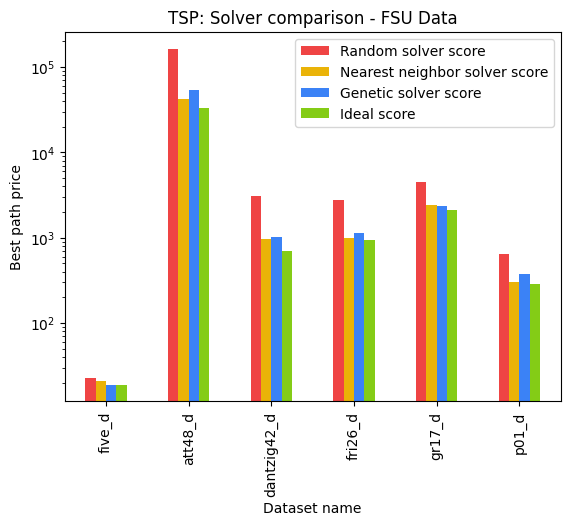

In [15]:
def plot_fsu_data_solved():
    y = ['Random solver score', 'Nearest neighbor solver score', 'Genetic solver score', 'Ideal score']
    fsu_data_solved.plot(x='Dataset name', y=y, color=get_solvers_colors(y),
                         ylabel='Best path price', kind='bar', logy=True,
                         title='TSP: Solver comparison - FSU Data'
                         )
plot_fsu_data_solved()

### Exploring genetic algorithm parameters
The genetic algorithm provides a lot of parameters with which it can be configured. In this section, we will explore them and see how they affect genetic algorithm performance.

#### Number of generations

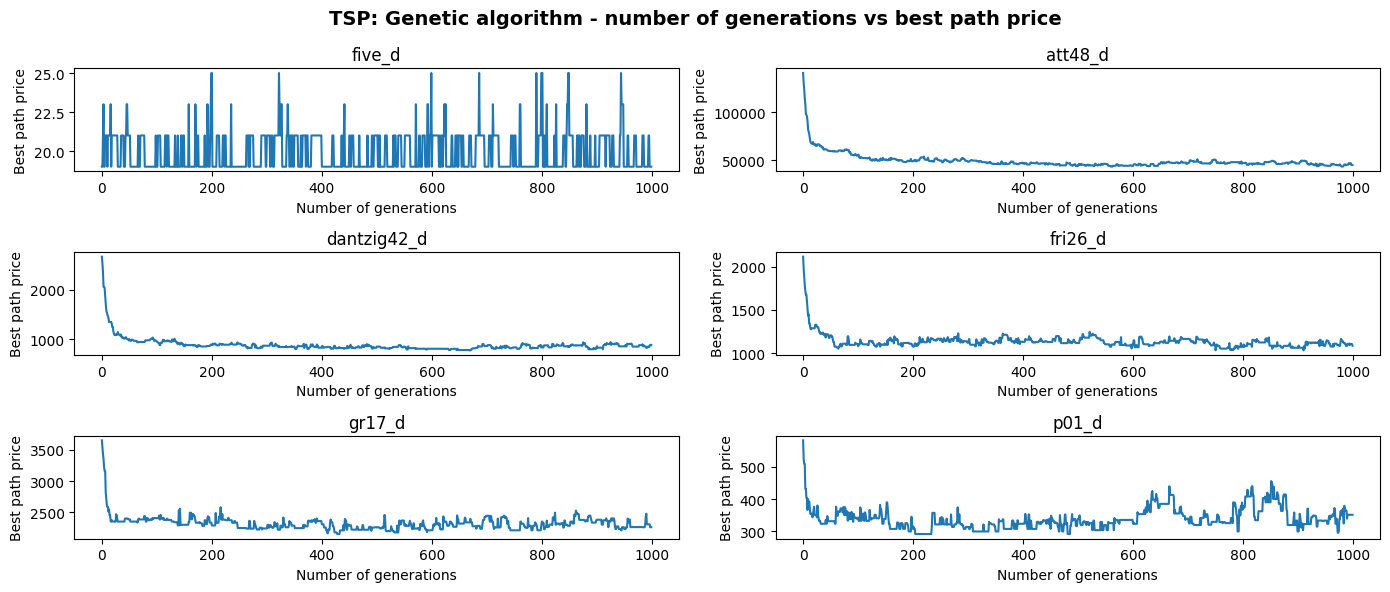

In [16]:
def plot_genetic_solver__score_vs_number_of_generations_tmp(data):
    fig, axs = plt.subplots(3, 2, figsize=(14, 6))
    for index, (name, best_path_price, rates) in enumerate(data):
        generations = GeneticSolver(rates=rates, number_of_generations=1000).run(collect_each_generation=True)
        ax = axs.flat[index]
        ax.plot([generation[1] for generation in generations])
        ax.set_title(name)
        ax.set_ylabel('Best path price')
        ax.set_xlabel('Number of generations')
    fig.suptitle('TSP: Genetic algorithm - number of generations vs best path price', fontsize=14, fontweight='bold')
    fig.tight_layout()
plot_genetic_solver__score_vs_number_of_generations_tmp(fsu_data)

#### Population size

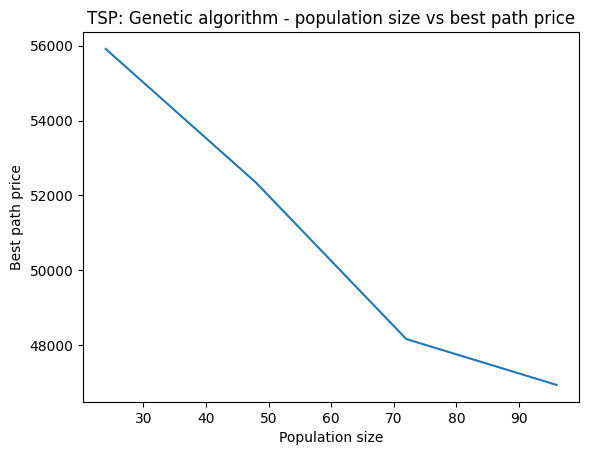

In [17]:
def plot_genetic_solver__score_vs_population_size(dataset):
    result = [(i, np.mean([GeneticSolver(rates=dataset, population_size=i).solve()[1] for _ in range(3)])) for i in [24,48,72,96]]
    pd.DataFrame(result, columns=('Population size', 'Best path price')
                 ).plot(x='Population size', y='Best path price',
                        ylabel='Best path price', legend=False,
                        title='TSP: Genetic algorithm - population size vs best path price', 
                        )
plot_genetic_solver__score_vs_population_size(fsu_data[1][2])

#### Selection method

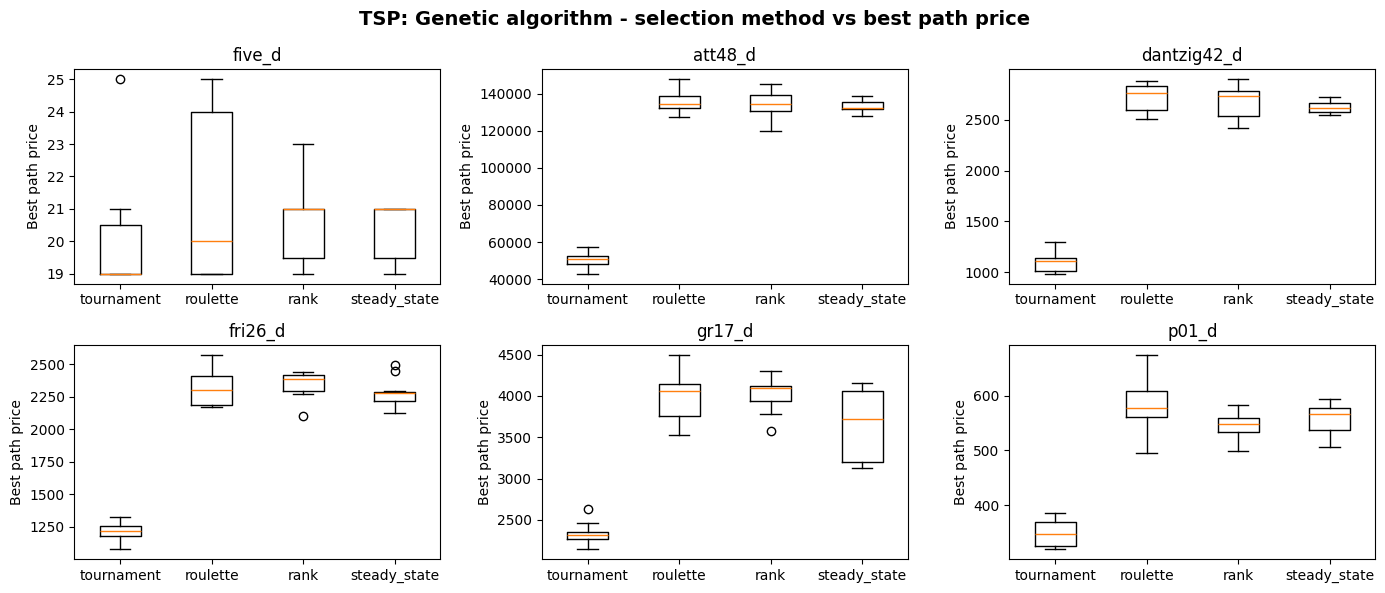

In [18]:
def plot_genetic_solver__score_vs_selection_method_tmp(data):
    SELECTION_METHODS = ['tournament', 'roulette', 'rank', 'steady_state']
    fig, axs = plt.subplots(2, 3, figsize=(14, 6))
    for index, (name, best_path_price, rates) in enumerate(data):
        result = []
        for selection_method in SELECTION_METHODS:
            selection_method_result = []
            for _ in range(10):
                selection_method_result.append(GeneticSolver(rates, selection_method=selection_method).solve()[1])
            result.append(selection_method_result)
        ax = axs.flat[index]
        ax.boxplot(result, tick_labels=SELECTION_METHODS)
        ax.set_title(name)
        ax.set_ylabel('Best path price')
    fig.suptitle('TSP: Genetic algorithm - selection method vs best path price', fontsize=14, fontweight='bold')
    fig.tight_layout()
plot_genetic_solver__score_vs_selection_method_tmp(fsu_data)

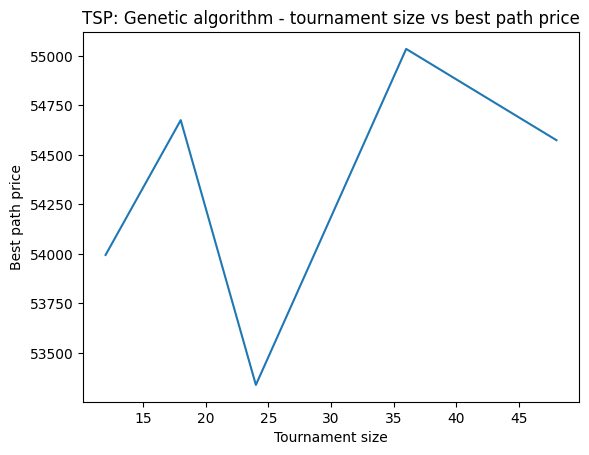

In [19]:
def plot_genetic_solver__score_vs_tournament_size(dataset):
    result = [(i, np.mean([GeneticSolver(rates=dataset, population_size=48, tournament_size=i).solve()[1] for _ in range(3)])) for i in [12,18,24,36,48]]
    pd.DataFrame(result, columns=('Tournament size', 'Best path price')
                 ).plot(x='Tournament size', y='Best path price',
                        ylabel='Best path price', legend=False,
                        title='TSP: Genetic algorithm - tournament size vs best path price',
                        )
plot_genetic_solver__score_vs_tournament_size(fsu_data[1][2])

#### Mutation rate

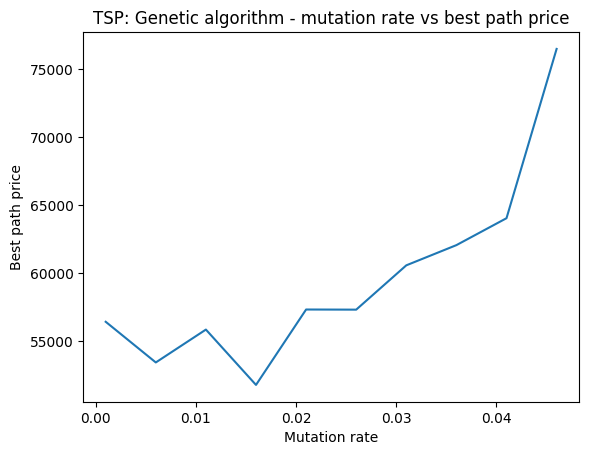

In [20]:
def plot_genetic_solver__score_vs_mutation_rate(dataset):
    result = [(i, np.mean([GeneticSolver(rates=dataset, mutation_rate=i).solve()[1] for _ in range(3)])) for i in np.arange(0.001, 0.05, 0.005)]
    pd.DataFrame(result, columns=('Mutation rate', 'Best path price')
                 ).plot(x='Mutation rate', y='Best path price',
                        ylabel='Best path price', legend=False,
                        title='TSP: Genetic algorithm - mutation rate vs best path price',
                        )
plot_genetic_solver__score_vs_mutation_rate(fsu_data[1][2])

## Optimization
The fundamental problem with the implementation described above turned out to be the population initialization method. In this section, we're going to use the NN algorithm to initialize the genetic algorithm population. We will consider 2 techniques, where:
1. The initial population contains *n* individuals determined via NN algorithm - each with another starting node.
2. The initial population additionally contains *n* random individuals - in this method, the total population size is *2n*.

### First approach

In [21]:
def initialize_population_nn(rates):
    nodes = [i for i in range(len(rates))]
    population = []
    for node in nodes:
        population.append(NearestNeighborSolver(rates, start_node=node).solve()[0])
    return population
nn_initialized_genetic_solver_factory = lambda rates: GeneticSolver(rates=rates, initial_population=initialize_population_nn(rates), mutation_rate=0.015)

In [22]:
def solve_and_add_to_df(solver_factory, solver_name, df, data):
    scores = []
    for rates in data:
        scores.append(solver_factory(rates).solve_and_measure_time())
    return df.assign(**{f'{solver_name} solver score': [score[1] for score in scores],
                        f'{solver_name} solver time': [TSPUtils.parse_timedelta(score[2]) for score in scores]
                        })

In [23]:
randomized_data_2_solved_with_genetic_nn = solve_and_add_to_df(nn_initialized_genetic_solver_factory, 'Genetic-NN', randomized_data_2_solved, randomized_data_2)

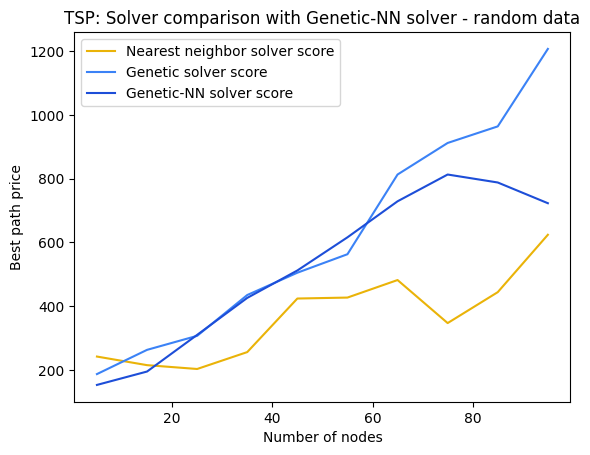

In [24]:
def plot_randomized_data_2_solved_with_genetic_nn():
    y = ['Nearest neighbor solver score', 'Genetic solver score', 'Genetic-NN solver score']
    randomized_data_2_solved_with_genetic_nn.plot(x='Number of nodes', y=y, color=get_solvers_colors(y),
                                                  ylabel='Best path price',
                                                  title='TSP: Solver comparison with Genetic-NN solver - random data'
                                                  )
plot_randomized_data_2_solved_with_genetic_nn()

In [25]:
fsu_data_solved_with_genetic_nn = solve_and_add_to_df(nn_initialized_genetic_solver_factory, 'Genetic-NN', fsu_data_solved, [fsu_dataset[2] for fsu_dataset in fsu_data])
fsu_data_solved_with_genetic_nn

,Dataset name,Number of nodes,Ideal score,Exact algorithm estimated time,Random solver score,Random solver time,Nearest neighbor solver score,Nearest neighbor solver time,Genetic solver score,Genetic solver time,Genetic-NN solver score,Genetic-NN solver time
0,five_d,5,19,< 1 ms,23.0,< 1 ms,21.0,< 1 ms,19.0,4.06 ms,21.0,5.03 ms
1,att48_d,48,33523,6.88e+47 years,163989.0,< 1 ms,42182.0,< 1 ms,53807.0,664.18 ms,46933.0,735.43 ms
2,dantzig42_d,42,699,7.78e+37 years,3094.0,< 1 ms,973.0,< 1 ms,1032.0,457.18 ms,931.0,552.04 ms
3,fri26_d,26,937,2.23e+13 years,2762.0,< 1 ms,998.0,< 1 ms,1136.0,136.71 ms,1103.0,149.24 ms
4,gr17_d,17,2085,19.70 years,4556.0,< 1 ms,2415.0,< 1 ms,2358.0,45.02 ms,2273.0,44.12 ms
5,p01_d,15,291,26.46 days,642.0,< 1 ms,299.0,< 1 ms,374.0,34.49 ms,359.0,38.79 ms


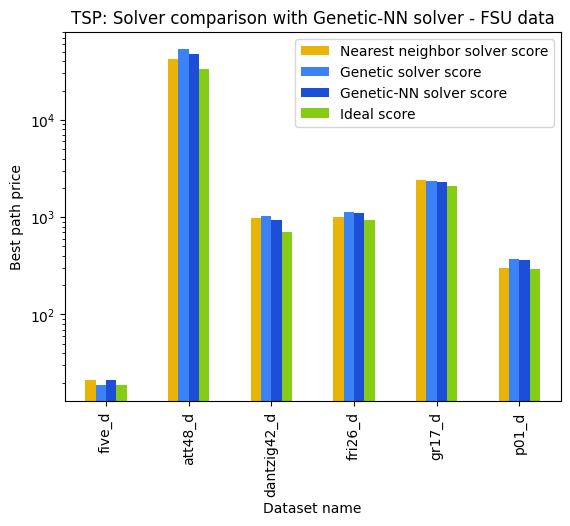

In [26]:
def plot_fsu_data_solved_with_genetic_nn():
    y = ['Nearest neighbor solver score', 'Genetic solver score', 'Genetic-NN solver score', 'Ideal score']
    fsu_data_solved_with_genetic_nn.plot(x='Dataset name', y=y, color=get_solvers_colors(y),
                                         ylabel='Best path price', kind='bar', logy=True,
                                         title='TSP: Solver comparison with Genetic-NN solver - FSU data'
                                         )
plot_fsu_data_solved_with_genetic_nn()

### Second approach

In [27]:
def initialize_population_nn_rand(rates):
    nodes = [i for i in range(len(rates))]
    population = []
    for node in nodes:
            population.append(NearestNeighborSolver(rates, start_node=node).solve()[0])
            population.append(np.random.permutation(nodes))
    np.random.shuffle(population)
    return population
nn_rand_initialized_genetic_solver_factory = lambda rates: GeneticSolver(rates=rates, initial_population=initialize_population_nn_rand(rates), population_size=len(rates)*2,mutation_rate=0.015)

In [28]:
randomized_data_2_solved_full = solve_and_add_to_df(nn_rand_initialized_genetic_solver_factory, 'Genetic-NN-rand', randomized_data_2_solved_with_genetic_nn, randomized_data_2)

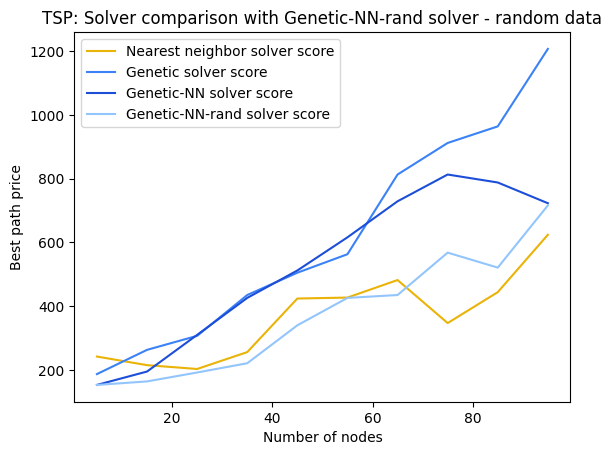

In [29]:
def plot_randomized_data_2_solved_full():
    y = ['Nearest neighbor solver score', 'Genetic solver score', 'Genetic-NN solver score', 'Genetic-NN-rand solver score']
    randomized_data_2_solved_full.plot(x='Number of nodes', y=y, color=get_solvers_colors(y),
                                       ylabel='Best path price',
                                       title='TSP: Solver comparison with Genetic-NN-rand solver - random data'
                                       )
plot_randomized_data_2_solved_full()

In [30]:
fsu_data_solved_full = solve_and_add_to_df(nn_rand_initialized_genetic_solver_factory, 'Genetic-NN-rand', fsu_data_solved_with_genetic_nn, [fsu_dataset[2] for fsu_dataset in fsu_data])
fsu_data_solved_full

,Dataset name,Number of nodes,Ideal score,Exact algorithm estimated time,Random solver score,Random solver time,Nearest neighbor solver score,Nearest neighbor solver time,Genetic solver score,Genetic solver time,Genetic-NN solver score,Genetic-NN solver time,Genetic-NN-rand solver score,Genetic-NN-rand solver time
0,five_d,5,19,< 1 ms,23.0,< 1 ms,21.0,< 1 ms,19.0,4.06 ms,21.0,5.03 ms,19.0,12.51 ms
1,att48_d,48,33523,6.88e+47 years,163989.0,< 1 ms,42182.0,< 1 ms,53807.0,664.18 ms,46933.0,735.43 ms,45492.0,2.46 s
2,dantzig42_d,42,699,7.78e+37 years,3094.0,< 1 ms,973.0,< 1 ms,1032.0,457.18 ms,931.0,552.04 ms,802.0,1.66 s
3,fri26_d,26,937,2.23e+13 years,2762.0,< 1 ms,998.0,< 1 ms,1136.0,136.71 ms,1103.0,149.24 ms,955.0,468.67 ms
4,gr17_d,17,2085,19.70 years,4556.0,< 1 ms,2415.0,< 1 ms,2358.0,45.02 ms,2273.0,44.12 ms,2178.0,158.34 ms
5,p01_d,15,291,26.46 days,642.0,< 1 ms,299.0,< 1 ms,374.0,34.49 ms,359.0,38.79 ms,291.0,121.76 ms


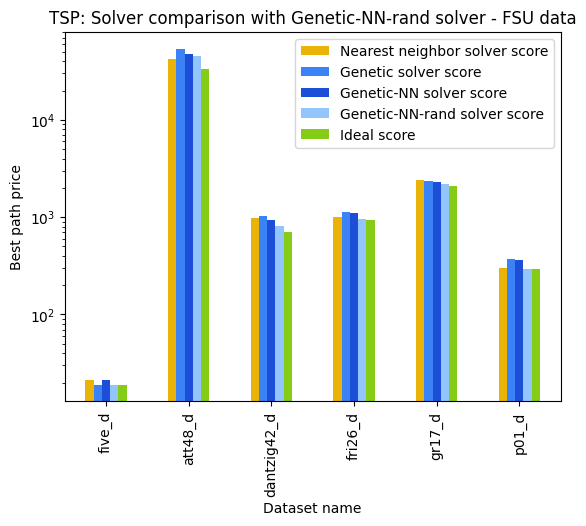

In [31]:
def plot_fsu_data_solved_full():
    y = ['Nearest neighbor solver score', 'Genetic solver score', 'Genetic-NN solver score', 'Genetic-NN-rand solver score', 'Ideal score']
    fsu_data_solved_full.plot(x='Dataset name', y=y , color=get_solvers_colors(y),
                              ylabel='Best path price', kind='bar', logy=True,
                              title='TSP: Solver comparison with Genetic-NN-rand solver - FSU data'
                              )
plot_fsu_data_solved_full()